In [1]:
%pylab inline
import gc
import numpy as np
import fitsio
import astropy.io.fits as pyfits
import numpy.lib.recfunctions as rfn
import astropy.table as astTable

from fpfs import fpfsBase
import imgSimutil

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd wrkDir/FPFS2/sim

/lustre/work/xiangchong.li/work/FPFS2/sim


In [3]:
pltDir='plot/smallcat/'
if not os.path.isdir(pltDir):
    os.mkdir(pltDir)

In [6]:
vdir='outSmall0-var7em3'
ngroup=16
igroup=0
C=20000.
noiRev=False
g1p=0.;g1m=0.
downp=0.;downm=0.
for ifield in range(100):
    fname1=os.path.join(vdir,'fpfs-rcut16-psf60-%d/src%04d-g1-2222.fits' %(igroup,ifield))
    moments1=pyfits.getdata(fname1)
    elli1=fpfsBase.fpfsM2E(moments1,C,rev=noiRev)
    g1p+=np.sum(elli1['fpfs_e1'])
    downp+=np.sum(elli1['fpfs_RE'])

    fname2=os.path.join(vdir,'fpfs-rcut16-psf60-%d/src%04d-g1-0000.fits' %(igroup,ifield))
    moments2=pyfits.getdata(fname2)
    elli2=fpfsBase.fpfsM2E(moments2,C,rev=noiRev)
    g1m+=np.sum(elli2['fpfs_e1'])
    downm+=np.sum(elli2['fpfs_RE'])
    del elli1,elli2,moments1,moments2
    gc.collect()
print((g1p-g1m)/(downm+downp)*2./0.04-1)
print((g1p+g1m)/(downm+downp))

-0.008675331452172474
-0.0016619972188736502


In [3]:
def estimateA(slow=0.15,C=2000.,noiRev=True,nsRev=True):
    vdir='outcome-var7em3'
    ngroup=16
    nsim=ngroup*250
    nic=3
    dss=0.01
    if nsRev:
        de1=np.load(os.path.join(errDir,'deList_C%d_2222_low15_redshift3.npy' %(int(C))),allow_pickle=True).item()['deList']
        de2=np.load(os.path.join(errDir,'deList_C%d_0000_low15_redshift3.npy' %(int(C))),allow_pickle=True).item()['deList']
        assert len(de1)==nic
    else:
        de1=np.zeros(nic)
        de2=np.zeros(nic)
    gest=np.zeros((nsim,nic))
    dest=np.zeros((nsim,nic))
    for igroup in range(ngroup):
        zUse=hscCat[10000*(igroup%8):10000*(igroup%8+1)]['zphot']
        for igf in range(250):
            ifield=igroup*250+igf
            fname1=os.path.join(vdir,'fpfs-rcut16-psf60-%d/src%04d-g1-2222.fits' %(igroup,ifield))
            moments1=pyfits.getdata(fname1)
            elli1=fpfsM2E(moments1,C,rev=noiRev)
            mask1A=elli1['fpfs_s0']>slow
            
            fname2=os.path.join(vdir,'fpfs-rcut16-psf60-%d/src%04d-g1-0000.fits' %(igroup,ifield))
            moments2=pyfits.getdata(fname2)
            elli2=fpfsM2E(moments2,C,rev=noiRev)
            mask2A=elli2['fpfs_s0']>slow
            for ic in range(nic):
                zlow=0.6*(ic)
                zhigh=0.6*(1+ic)
                maskZ= (zUse>zlow)&(zUse<=zhigh)
                eTmp=elli1[maskZ&mask1A]
                mskTmp=(eTmp['fpfs_s0']<=slow+dss)
                RS=-np.sum(eTmp[mskTmp]['fpfs_RS']/dss)
                g1p=np.sum(eTmp['fpfs_e1']-de1[ic])
                downp=(np.sum(eTmp['fpfs_RE'])+RS)
                del eTmp,mskTmp
                gc.collect()

                eTmp=elli2[maskZ&mask2A]
                mskTmp=(eTmp['fpfs_s0']<=slow+dss)
                RS=-np.sum(eTmp[mskTmp]['fpfs_RS']/dss)
                g1m=np.sum(eTmp['fpfs_e1']-de2[ic])
                downm=np.sum(eTmp['fpfs_RE'])+RS
                del eTmp,mskTmp,maskZ
                gc.collect()
                gest[ifield,ic]=(g1m+g1p)/2.
                dest[ifield,ic]=(downm+downp)/2.
            del elli1,elli2,mask1A,mask2A,moments1,moments2
            gc.collect
    return -np.average(gest,axis=0)/np.average(dest,axis=0),np.std(gest,axis=0)/np.sqrt(nsim)/np.average(dest,axis=0)

def fpfsM2E(moments,const=2000.,mcalib=0.,rev=False):
    """
    # Estimate FPFS ellipticities from fpfs moments

    Parameters:
    -----------
    moments:    input FPFS moments     [float array]
    const:      the weighting Constant [float]
    mcalib:     multiplicative bias [float array]

    Returns:
    -------------
    out :       an array of FPFS ellipticities,
                FPFS ellipticity response,
                FPFS flux ratio, and FPFS selection response
    """
    #Get weight
    weight  =   1./(moments['fpfs_M00']+const)
    #Ellipticity
    e1      =   moments['fpfs_M22c']*weight
    e2      =   moments['fpfs_M22s']*weight
    e1sq    =   e1*e1
    e2sq    =   e2*e2
    #FPFS flux ratio
    s0      =   moments['fpfs_M00']*weight
    s4      =   moments['fpfs_M40']*weight
    #FPFS sel Respose (part1)
    e1sqS0  =   e1sq*s0
    e2sqS0  =   e2sq*s0

    if rev:
        assert 'fpfs_N00N00' in moments.dtype.names
        assert 'fpfs_N00N22c' in moments.dtype.names
        assert 'fpfs_N00N22s' in moments.dtype.names
        assert 'fpfs_N00N40' in moments.dtype.names
        ratio=  moments['fpfs_N00N00']*weight**2.
        weight= weight/(1+ratio)
        ratio=  moments['fpfs_N00N00']*weight**2.
        
        e1  =   (e1+moments['fpfs_N00N22c']\
                *weight**2.)/(1+ratio)
        e2  =   (e2+moments['fpfs_N00N22s']\
                *weight**2.)/(1+ratio)
        e1sq=   (e1sq-moments['fpfs_N22cN22c']*weight**2.\
                +4.*e1*moments['fpfs_N00N22c']*weight**2.)\
                /(1.+3*ratio)
        e2sq=   (e2sq-moments['fpfs_N22sN22s']*weight**2.\
                +4.*e2*moments['fpfs_N00N22s']*weight**2.)\
                /(1.+3*ratio)
        s0  =   (s0+moments['fpfs_N00N00']\
                *weight**2.)/(1+ratio)
        s4  =   (s4+moments['fpfs_N00N40']\
                *weight**2.)/(1+ratio)
        
        e1sqS0= (e1sqS0+3.*e1sq*moments['fpfs_N00N00']*weight**2.\
                -s0*moments['fpfs_N22cN22c']*weight**2.\
                -2*e1*(1-3*s0)*moments['fpfs_N00N22c']*weight**2.\
                 )/(1+6.*ratio)
        e2sqS0= (e2sqS0+3.*e2sq*moments['fpfs_N00N00']*weight**2.\
                -s0*moments['fpfs_N22sN22s']*weight**2.\
                -2*e2*(1-3*s0)*moments['fpfs_N00N22s']*weight**2.\
                 )/(1+6.*ratio)
        
    eSq     =   e1sq+e2sq
    eSqS0   =   e1sqS0+e2sqS0
    #Response factor
    RE      =   1./np.sqrt(2.)*(s0-s4+e1sq+e2sq)
    types   =   [('fpfs_e1','>f8'),('fpfs_e2','>f8'),('fpfs_RE','>f8'),\
                ('fpfs_s0','>f8'), ('fpfs_eSquare','>f8'), ('fpfs_RS','>f8')]
    ellDat  =   np.array(np.zeros(moments.size),dtype=types)
    ellDat['fpfs_e1']   =   e1
    ellDat['fpfs_e2']   =   e2
    ellDat['fpfs_RE']   =   RE
    ellDat['fpfs_s0']   =   s0
    ellDat['fpfs_eSquare']  =   eSq
    ellDat['fpfs_RS']   =   (eSq-eSqS0)/np.sqrt(2.)
    return ellDat

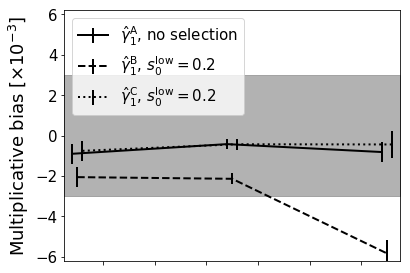

In [112]:
CBase=2000.
islow=0.20
pend='low%03d' %(int(islow*100))
nameT=os.path.join(pltDir,'outT_%s.fits' %pend )
if os.path.isfile(nameT):
    outT=astTable.Table.read(nameT)
    mT=outT['m']
    merrT=outT['mErr']
else:
    mT,merrT=estimate(slow=islow,C=CBase,noiRev=True,nsRev=True)
    outT=astTable.Table()
    outT['m']=mT
    outT['mErr']=merrT
    outT.write(nameT)

nameF=os.path.join(pltDir,'outF_%s.fits' %pend)
if os.path.isfile(nameF):
    outF=astTable.Table.read(nameF)
    mF=outF['m']
    merrF=outF['mErr']
else:
    mF,merrF=estimate(slow=islow,C=CBase,noiRev=True,nsRev=False)
    outF=astTable.Table()
    outF['m']=mF
    outF['mErr']=merrF
    outF.write(nameF)
    
nameX=os.path.join(pltDir,'outF_lowxxx.fits')
if os.path.isfile(nameX):
    outX=astTable.Table.read(nameX)
    mX=outX['m']
    merrX=outX['mErr']
else:
    mX,merrX=estimate(slow=-0.25,C=CBase,noiRev=True,nsRev=False)
    outX=astTable.Table()
    outX['m']=mX
    outX['mErr']=merrX
    outX.write(nameX)
    
plt.close()
fig=plt.figure(figsize=(6,8))
ax=fig.add_subplot(2,1,1)
zlist=np.array([0.3,0.9,1.5])
ax.errorbar(zlist-0.02,mX*1000,merrX*1000,fmt='-',c='black',linewidth=2,label=r'$\hat{\gamma}^{\rm A}_1$, no selection')
ax.errorbar(zlist,mF*1000,merrF*1000,fmt='--',c='black',linewidth=2,label=r'$\hat{\gamma}^{\rm B}_1$, $s_0^{\rm low}=%s$' %islow)
ax.errorbar(zlist+0.02,mT*1000,merrT*1000,fmt=':',c='black',linewidth=2,label=r'$\hat{\gamma}^{\rm C}_1$, $s_0^{\rm low}=%s$' %islow)
ax.fill_between(np.linspace(0.25,1.55,100),-3e0*np.ones(100),3e0*np.ones(100),color='gray',alpha=0.6)
ax.set_xlim(0.25,1.55)
ax.set_ylim(-6.2,6.2)
ax.set_ylabel(r'Multiplicative bias [$\times 10^{-3}$]')
ax.set_xticklabels([])
ax.legend(loc='upper left',fontsize=15)

In [113]:
CBase=2000.
nameT=os.path.join(pltDir,'outAT_%s.fits' %pend)
if os.path.isfile(nameT):
    outT=astTable.Table.read(nameT)
    cT=outT['c']
    cerrT=outT['cErr']
else:
    cT,cerrT=estimateA(slow=islow,C=CBase,noiRev=True,nsRev=True)
    outT=astTable.Table()
    outT['c']=cT
    outT['cErr']=cerrT
    outT.write(nameT)

nameF=os.path.join(pltDir,'outAF_%s.fits' %pend)
if os.path.isfile(nameF):
    outF=astTable.Table.read(nameF)
    cF=outF['c']
    cerrF=outF['cErr']
else:
    cF,cerrF=estimateA(slow=islow,C=CBase,noiRev=True,nsRev=False)
    outF=astTable.Table()
    outF['c']=cF
    outF['cErr']=cerrF
    outF.write(nameF)
nameX=os.path.join(pltDir,'outAF_lowxxx.fits')
if os.path.isfile(nameX):
    outX=astTable.Table.read(nameX)
    cX=outX['c']
    cerrX=outX['cErr']
else:
    cX,cerrX=estimateA(slow=-0.25,C=CBase,noiRev=True,nsRev=False)
    outX=astTable.Table()
    outX['c']=cX
    outX['cErr']=cerrX
    outX.write(nameX)
    
ax2=fig.add_subplot(2,1,2)
zlist=np.array([0.3,0.9,1.5])
ax2.errorbar(zlist-0.02,cX*10000,cerrX*10000,fmt='-',c='black',linewidth=2,label=r'$\hat{\gamma}^{\rm A}_1$, no selection')
ax2.errorbar(zlist,cF*10000,cerrF*10000,fmt='--',c='black',linewidth=2,label=r'$\hat{\gamma}^{\rm B}_1$, $s_0^{\rm low}=%s$' %islow)
ax2.errorbar(zlist+0.02,cT*10000,cerrT*10000,fmt=':',c='black',linewidth=2,label=r'$\hat{\gamma}^{\rm C}_1$, $s_0^{\rm low}=%s$' %islow)
ax2.set_xlim(0.25,1.55)
ax2.set_ylim(-5,5.)
ax2.set_xlabel(r'redshift')
ax2.set_ylabel(r'Additive bias [$\times 10^{-4}$]')
#plt.tight_layout()
fig.subplots_adjust(right=0.99,hspace = 0.05,top=0.98,bottom=0.1)

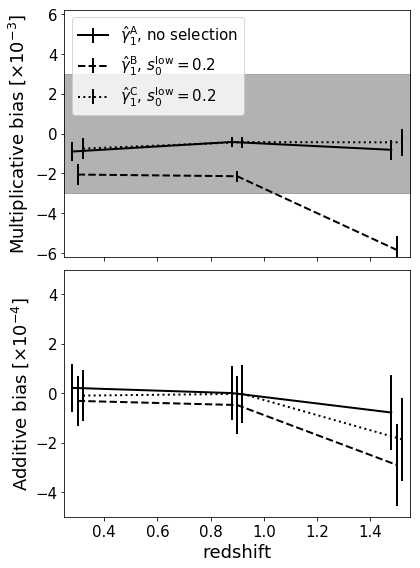

In [114]:
fig

In [115]:
fig
fig.savefig(os.path.join(pltDir,'redshift_depend.png'))
fig.savefig(os.path.join(pltDir,'redshift_depend.pdf'))

/lustre/work/xiangchong.li/ana/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


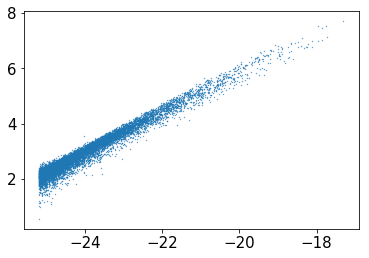

In [29]:
if False:
    fname=os.path.join(vdir,'fpfs-rcut16-psf60-%d/src%04d-g1-2222.fits' %(0,0))
    moments=pyfits.getdata(fname)
    plt.scatter(-hscCat[:10000]['mag_auto'],log10(moments['fpfs_M00']),s=0.1)

(array([2.6240e+03, 8.0590e+03, 8.6680e+03, 9.4150e+03, 1.1206e+04,
        8.8070e+03, 7.9740e+03, 5.0330e+03, 3.6930e+03, 2.4640e+03,
        2.4350e+03, 1.8240e+03, 1.4210e+03, 1.2740e+03, 1.5070e+03,
        9.7000e+02, 6.6300e+02, 6.1600e+02, 4.5000e+02, 2.9700e+02,
        1.6200e+02, 1.7900e+02, 6.8000e+01, 5.5000e+01, 4.7000e+01,
        4.2000e+01, 2.3000e+01, 1.3000e+01, 6.0000e+00, 5.0000e+00]),
 array([4.99999989e-03, 1.85113335e-01, 3.65226670e-01, 5.45340006e-01,
        7.25453341e-01, 9.05566676e-01, 1.08568001e+00, 1.26579335e+00,
        1.44590668e+00, 1.62602002e+00, 1.80613335e+00, 1.98624669e+00,
        2.16636002e+00, 2.34647336e+00, 2.52658669e+00, 2.70670003e+00,
        2.88681336e+00, 3.06692670e+00, 3.24704004e+00, 3.42715337e+00,
        3.60726671e+00, 3.78738004e+00, 3.96749338e+00, 4.14760671e+00,
        4.32772005e+00, 4.50783338e+00, 4.68794672e+00, 4.86806005e+00,
        5.04817339e+00, 5.22828672e+00, 5.40840006e+00]),
 <a list of 30 Patch objects

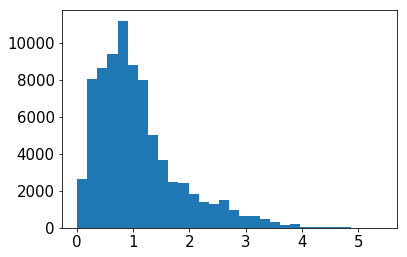

In [20]:
if False:
    plt.hist(hscCat['zphot'][:80000],bins=30)

In [55]:
def wlmask(dd):
    centDis=  np.sqrt((dd['base_SdssCentroid_y']%ngrid-ngrid/2)**2. +
              (dd['base_SdssCentroid_x']%ngrid-ngrid/2)**2.)
    mask = (~np.isnan(dd['modelfit_CModel_instFlux']))&\
        (~np.isnan(dd['modelfit_CModel_instFluxErr'])) &\
        (~np.isnan(dd['ext_shapeHSM_HsmShapeRegauss_resolution'])) &\
        (dd['deblend_nChild']  ==  0) &\
        (centDis<8.)
    dd   =   dd[mask]
    centDis= centDis[mask]
    ipos =   np.int_(dd['base_SdssCentroid_y']//64)*100+np.int_(dd['base_SdssCentroid_x']//64)
    inds =   np.lexsort([centDis, ipos])
    dd   =   dd[inds]
    ipos =   ipos[inds]
    inds_unique =   np.unique(ipos, return_index=True)[1]
    dd   =  dd[inds_unique]
    return dd
    
cosmo252=   imgSimutil.cosmoHSTGal('252')
cosmo252.readHSTsample()
hscCat  =   cosmo252.catused
vdir='outBasic-var7em3'
ngroup=8
nsim=ngroup*1
nic=3

In [76]:
C=2000.
ngrid=64
snrAll=np.zeros(nic)
resAll=np.zeros(nic)
snr2All=np.zeros(nic)
res2All=np.zeros(nic)
nAll=np.zeros(nic)
for igroup in range(8):
    zUse=hscCat[10000*(igroup%8):10000*(igroup%8+1)]['zphot']
    ifield=igroup*250
    fname=os.path.join(vdir,'fpfs-rcut16-psf60-%d/src%04d-g1-0000.fits' %(igroup,ifield))
    mmt=fitsio.read(fname)
    ell=fpfsBase.fpfsM2E(mmt,C,rev=True)
    ids1=np.arange(len(ell))
    fname=os.path.join(vdir,'src-psf60-%d/src%04d-g1-2222.fits' %(igroup,ifield))
    src=fitsio.read(fname)
    src=wlmask(src)
    ids2=np.int_(src['base_SdssCentroid_y']//64)*100+np.int_(src['base_SdssCentroid_x']//64)
    mask=np.in1d(ids1,ids2,assume_unique=True)
    ell=ell[mask]
    zUse=zUse[mask]
    del mask,ell
    gc.collect()
    for ic in range(nic):
        zlow=0.6*(ic)
        zhigh=0.6*(1+ic)
        maskZ= (zUse>=zlow)&(zUse<=zhigh)
        srcU=src[maskZ]
        snr=srcU['modelfit_CModel_instFlux']/srcU['modelfit_CModel_instFluxErr']
        res=srcU['ext_shapeHSM_HsmShapeRegauss_resolution']
        resAll[ic]+=np.sum(res)
        snrAll[ic]+=np.sum(snr)
        res2All[ic]+=np.sum(res**2.)
        snr2All[ic]+=np.sum(snr**2.)
        #snrAll[ic]+=np.sum(srcU[ 'base_CircularApertureFlux_3_0_instFlux']/srcU[ 'base_CircularApertureFlux_3_0_instFluxErr'])
        nAll[ic]+=len(srcU)
        del srcU
        gc.collect()

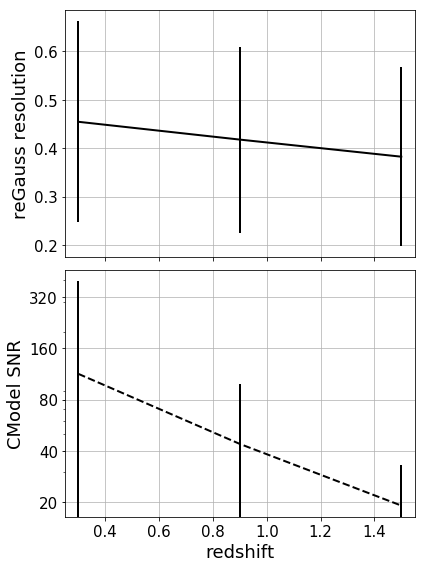

In [99]:
fig=plt.figure(figsize=(6,8))
zbins=np.array([0.3,0.9,1.5])
ax1=fig.add_subplot(2,1,1)
aveRes=resAll/nAll
stdRes=np.sqrt(res2All/nAll-aveRes**2.)
ax1.errorbar(zbins,aveRes,stdRes,c='black',ls='-')
ax1.set_xlim(0.25,1.55)
ax1.set_ylabel('reGauss resolution')
ax1.set_xticklabels([])
ax1.grid()

ax2=fig.add_subplot(2,1,2)
aveSnr=snrAll/nAll
stdSnr=np.sqrt(snr2All/nAll-aveSnr**2.)
ax2.errorbar(zbins,aveSnr,stdSnr,c='black',ls='--')
ax2.set_yscale('log')
ax2.set_xlim(0.25,1.55)
ax2.set_ylabel('CModel SNR')
ax2.set_yticklabels(['20','40','80','160','320'])
ax2.set_yticks([20,40,80,160,320])
ax2.set_xlabel('redshift')
ax2.grid()
fig.subplots_adjust(left=0.18,right=0.99,hspace = 0.05,top=0.98,bottom=0.1)
fig.savefig(os.path.join(pltDir,'redshift_snrres.png'))
fig.savefig(os.path.join(pltDir,'redshift_snrres.pdf'))

In [34]:
mask=np.in1d(ids1,ids2,assume_unique=True)
print(len(mask))
np.sum(mask)

10000


8371

In [28]:
len(src2)

8371

In [ ]:
    for ic in range(nic):
        zlow=0.6*(ic)
        zhigh=0.6*(1+ic)
        maskZ= (zUse>zlow)&(zUse<=zhigh)
        gest[ifield,ic]=(g1m+g1p)/2.
        dest[ifield,ic]=(downm+downp)/2.
        gc.collect()